# Implement Conditional GAN on Accelerometer Data

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path

In [72]:
DATA_DIR = f'{os.path.expanduser("~")}/.delta/nursing_pt'
import math
from torch.nn import functional as F
from datetime import timedelta

def pad_for_windowing(X: torch.Tensor, winsize: int) -> torch.Tensor:
    p = winsize
    X = nn.functional.pad(X, (0, 0, 0, p), "constant", 0)
    return X
class WindowedDatasetWithStrideAndModeOfLabel(torch.utils.data.Dataset):
    def __init__(self, nurse, windowsize=1, stride=1):
        self.windowsize = windowsize
        self.stride = stride
        self.channels = 3
        self.X,self.y = torch.load(f'{DATA_DIR}/{nurse}.pt')
        self.len = math.ceil(len(self.X)/self.stride)
        
        self.X = torch.cat([self.X,torch.zeros(self.windowsize-1,3)])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (
            self.X[(idx*self.stride):(idx*self.stride)+self.windowsize].transpose(0,1),
            self.y[(idx*self.stride):(idx*self.stride)+self.windowsize].mode().values
        )
# Create dataset without zeros
class ZerolessDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.zero_idxs = []
        for i,(X,y) in enumerate(dataset):
            if y == 0:
                self.zero_idxs.append(i)
        self.idx_map = []
        for i in range(len(dataset)):
            if i in self.zero_idxs:
                continue
            self.idx_map.append(i)
    def __getitem__(self, i):
        X,y = self.dataset[self.idx_map[i]]
        return X,y

    def __len__(self):
        return len(self.dataset) - len(self.zero_idxs)
    
def load_nursing_5_class(nurses='all', winsize=2001, test_size=0.25, batch_size=512, stride=1, split=None):
    not_labeled = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    unlabled_sessions = set.intersection(set(nurses), not_labeled)
    if unlabled_sessions:
        raise ValueError(f"Session indexes {unlabled_sessions} are not labled")

    if nurses == 'all':
        nurses = list(range(11, 71))

    if stride == 'partition':
        stride = winsize

    def get_loader(idxs, shuffle):
        # return DataLoader(dataset=ConcatDataset([WindowedDatasetWithStrideAndModeOfLabel(nurse=idx,windowsize=winsize,stride=stride) for idx in idxs]),batch_size=batch_size,shuffle=shuffle)
        return DataLoader(dataset=ConcatDataset([ZerolessDataset(WindowedDatasetWithStrideAndModeOfLabel(nurse=idx,windowsize=winsize,stride=stride)) for idx in idxs]),batch_size=batch_size,shuffle=shuffle)
    
    if test_size == 1:
        dev_idx = nurses
        devloader = get_loader(dev_idx, False)
        return None, devloader
    elif test_size == 0:
        train_idx = nurses
        trainloader = get_loader(train_idx, True)
        
        return trainloader, None
    
    if split:
        train_idx, dev_idx = split
        if set(train_idx).intersection(set(dev_idx)):
            raise ValueError(f"Train and dev indexes overlap")
        if set.intersection(set(train_idx).union(set(dev_idx)), not_labeled):
            raise ValueError(f"Some indexes are not labled")
    else:
        train_idx, dev_idx = train_test_split(nurses, test_size=test_size, random_state=0)
        print(dev_idx)
    trainloader = get_loader(train_idx, True)
    devloader = get_loader(dev_idx, False)
    
    return trainloader, devloader
class AccRawDatasetStrided(Dataset):
    def __init__(self, X, winsize, stride):
        super().__init__()
        self.winsize = winsize
        self.stride = stride
        self.X = X
    
    def __getitem__(self, i):
        if i >= self.__len__():
            raise IndexError("Index Out of Range")

        return self.X[i*self.stride:i*self.stride+self.winsize].T

    def __len__(self):
        return (len(self.X) - self.winsize) // self.stride + 1
    
    
def load_raw(raw_dir, winsize, n_hours=None, sessions=None, chunk_len_hrs=5, test_size=0.25, batch_size=64, shuffle_test=False, stride=1):
    raw_dir = Path(raw_dir)
    if n_hours and n_hours < chunk_len_hrs*2:
        raise ValueError(f"n_hours must be at least chunk_len_hrs*2 ({chunk_len_hrs*2})")

    n_samples = int(n_hours * 60 * 60 * 100) if n_hours else None   # number of samples at 100 Hz to get n_hours hours
    chunk_len = int(chunk_len_hrs * 60 * 60 * 100)                  # number of samples at 100 Hz to get chunk_len_hrs hours

    # Use all available sessions if none provided
    if sessions:
        sessions = [raw_dir / Path(session) for session in sessions]
    else:
        print("Using all available sessions")
        sessions = list(raw_dir.iterdir())
    print("Using Directories: "+str([session.name for session in sessions]))

    # Read all sessions from pt files
    accs = []
    for session_dir in sessions:
        accs.append(pad_for_windowing(torch.load(session_dir), winsize))

    # Concatenate all sessions and split into chunks of chunk_len samples
    all_acc = torch.cat(accs, axis=0)
    all_acc = all_acc[:len(all_acc) - len(all_acc) % chunk_len] # cut off very last part
    all_acc = all_acc.view(-1, chunk_len, 3)
    print(f"Created {len(all_acc)} chunks of length {chunk_len} samples each")

    if n_samples:
        # Randomly Select n_samples worth of chunks
        n_chunks = n_samples // chunk_len # if chunk_len_hrs is 5: 5 hours = 1 chunk, 10 hours = 2 chunks, etc.
        if n_chunks > len(all_acc):
            raise ValueError(f"n_hours ({n_hours}) is greater than the total number of hours ({len(all_acc)*chunk_len_hrs})")
        random.seed(10)
        idxs = random.sample(list(range(len(all_acc))), n_chunks)
        all_acc = all_acc[idxs]
        print(f"Randomly selected {n_chunks} chunks")

    # Split into train and test
    def proc(x):
        x = pad_for_windowing(x, winsize) # pad second dimension
        x = x.flatten(end_dim=1)
        return x
    np.random.seed(10)
    acctr, accte = map(proc, train_test_split(all_acc, test_size=test_size))

    print(f"Total train length: {timedelta(seconds=len(acctr) / 100)} ({len(acctr)} Samples)")
    print(f"Total test length: {timedelta(seconds=len(accte) / 100)} ({len(accte)} Samples)")

    Xtr = AccRawDatasetStrided(acctr, winsize, stride=stride)
    Xte = AccRawDatasetStrided(accte, winsize, stride=stride)

    trainloader = DataLoader(Xtr, batch_size=batch_size, shuffle=True, num_workers=4)
    testloader = DataLoader(Xte, batch_size=batch_size, shuffle=shuffle_test, num_workers=4)

    return trainloader, testloader


In [213]:
workers = 2         # Number of workers for dataloader
batch_size = 128    # Batch size during training
window_size = 1024  # Spatial length of data
nc = 3              # Number of channels
nz = 32            # Size of z latent vector (i.e. size of generator input)
ngf = 64            # Size of feature maps in generator
ndf = 64            # Size of feature maps in discriminator
num_epochs = 5      # Number of training epochs
lr = 0.0002         # Learning rate for optimizers
beta1 = 0.5         # Beta1 hyperparameter for Adam optimizers
ngpu = 2            # Number of GPUs available. Use 0 for CPU mode.
n_classes = 5       # Number of classes in the dataset
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Data

In [214]:
dataloader,_ = load_nursing_5_class(
    nurses='all',
    winsize=window_size,
    test_size=0,
    batch_size=batch_size,
    stride=window_size // 4
)
# trainloader, testloader = load_raw(
#     '/home/musa/.delta/raw_pt',
#     window_size,
#     test_size=0.01,
#     batch_size=batch_size,
#     shuffle_test=True,
#     chunk_len_hrs=0.25,
#     stride=window_size // 4
# )

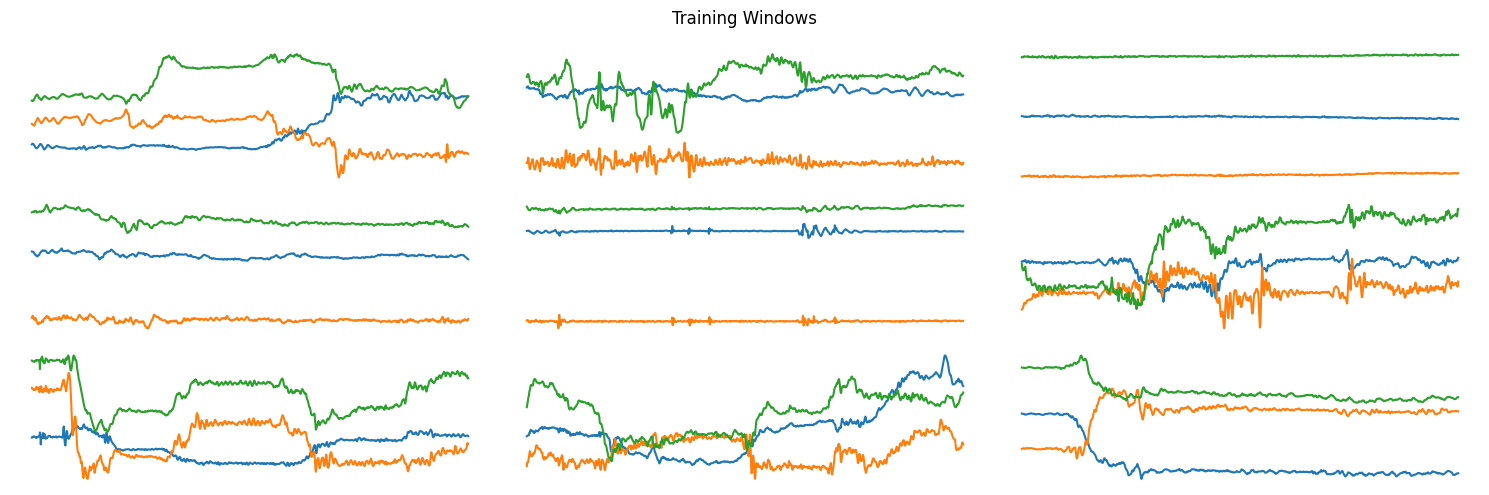

In [215]:
real_batch = next(iter(dataloader))
fig, axes = plt.subplots(3, 3, figsize=(15, 5))
plt.suptitle("Training Windows")
for i in range(9):
    axes.flatten()[i].plot(real_batch[0][i,0].numpy())
    axes.flatten()[i].plot(real_batch[0][i,1].numpy())
    axes.flatten()[i].plot(real_batch[0][i,2].numpy())
    axes.flatten()[i].axis("off")
plt.tight_layout()

# Models

In [216]:
# Weight initialization - call on model to initialize weights with N(0, 0.02)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [217]:
stride = 4
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        # self.embedding = nn.Embedding(n_classes, nz)
        self.main = nn.Sequential(
            # input Z is (nz) x 1, going into a convolution
            # nn.ConvTranspose1d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.ConvTranspose1d(nz+1, ngf * 8, 4, 1, 0, bias=False),
            nn.LayerNorm(4, elementwise_affine=False),
            nn.ReLU(True),
            # state size. (ngf*8) x 4
            nn.ConvTranspose1d(ngf * 8, ngf * 4, 4, 4, 0, bias=False),
            nn.LayerNorm(16, elementwise_affine=False),
            nn.ReLU(True),
            # state size. (ngf*4) x 16
            nn.ConvTranspose1d( ngf * 4, ngf * 2, 4, 4, 0, bias=False),
            nn.LayerNorm(64, elementwise_affine=False),
            nn.ReLU(True),
            # state size. (ngf*2) x 64
            nn.ConvTranspose1d( ngf * 2, ngf, 4, 4, 0, bias=False),
            nn.LayerNorm(256, elementwise_affine=False),
            nn.ReLU(True),
            # state size. (ngf) x 256
            nn.ConvTranspose1d( ngf, nc, 4, 4, 0, bias=False),
            # nn.Tanh()
            # state size. (nc) x 1024
        )

    def forward(self, input, labels):
        B, _, _ = input.size()
        # labels = self.embedding(labels)
        input = torch.cat([input, labels.unsqueeze(1).unsqueeze(2)], dim=1)
        return self.main(input)

In [218]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose1d(33, 512, kernel_size=(4,), stride=(1,), bias=False)
      (1): LayerNorm((4,), eps=1e-05, elementwise_affine=False)
      (2): ReLU(inplace=True)
      (3): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(4,), bias=False)
      (4): LayerNorm((16,), eps=1e-05, elementwise_affine=False)
      (5): ReLU(inplace=True)
      (6): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(4,), bias=False)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=False)
      (8): ReLU(inplace=True)
      (9): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(4,), bias=False)
      (10): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
      (11): ReLU(inplace=True)
      (12): ConvTranspose1d(64, 3, kernel_size=(4,), stride=(4,), bias=False)
    )
  )
)


## Discriminator

In [219]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.embedding = nn.Embedding(n_classes, window_size)
        self.main = nn.Sequential(
            # input is (nc) x 1024
            nn.Conv1d(nc+1, ndf, 4, 4, 1, bias=False),
            # nn.Conv1d(nc, ndf, 4, 4, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 256
            nn.Conv1d(ndf, ndf * 2, 4, 4, 1, bias=False),
            nn.LayerNorm(64, elementwise_affine=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64
            nn.Conv1d(ndf * 2, ndf * 4, 4, 4, 1, bias=False),
            nn.LayerNorm(16, elementwise_affine=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16
            nn.Conv1d(ndf * 4, ndf * 8, 4, 4, 1, bias=False),
            nn.LayerNorm(4, elementwise_affine=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4
            nn.Conv1d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
            # state size. 1 x 1
        )

    def forward(self, sig, labels):
        B, _, _ = sig.size()
        labels = self.embedding(labels)
        # Concatenate label embedding and signal to produce sig
        sig = torch.cat([sig, labels.unsqueeze(1)], dim=1)
        validity = self.main(sig)
        return validity

In [220]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (embedding): Embedding(5, 1024)
    (main): Sequential(
      (0): Conv1d(4, 64, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv1d(64, 128, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (3): LayerNorm((64,), eps=1e-05, elementwise_affine=False)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv1d(128, 256, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (6): LayerNorm((16,), eps=1e-05, elementwise_affine=False)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv1d(256, 512, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (9): LayerNorm((4,), eps=1e-05, elementwise_affine=False)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv1d(512, 1, kernel_size=(4,), stride=(1,), bias=False)
    )
  )
)


# Loss and Optimizers

In [221]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, device=device)
fixed_gen_labels = torch.randint(0, 5, (64,), device=device)

lambda_gp = 10

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [222]:
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
from torch import autograd
def compute_gradient_penalty(D, real_samples, fake_samples, y):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, y)
    fake = Variable(Tensor(real_samples.shape[0], 1, 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Train

In [223]:
from torch.autograd import Variable
from torch import FloatTensor, LongTensor
sig_list = []
G_losses = []
D_losses = []
iters = 0

netD.train()
netG.train()

num_epochs = 1000
for epoch in (pbar := tqdm(range(num_epochs))):
    # For each batch in the dataloader
    for i, (X,y) in enumerate(dataloader, 0):
        X,y = X.to(device), y.to(device)
        # Standardize X across channels
        X = (X - X.mean(dim=2, keepdim=True)) / X.std(dim=2, keepdim=True)

        ############################
        # (1) Update D network
        ###########################        
        real_batch = X.to(device)
        b_size = real_batch.size(0)
        noise = torch.randn(b_size, nz, 1, device=device) # b x nz x 1
        fake_y = torch.randint(1, n_classes, (b_size,), device=device)

        # Generate fake signal batch with G
        fake = netG(noise, fake_y).detach()

        # Train D
        netD.zero_grad()
        D_x = netD(real_batch, y)                       # Forward pass real batch through D
        D_G_z1 = netD(fake, fake_y)                          # Forward pass fake batch through D
        gradient_penalty = compute_gradient_penalty(netD, real_batch, fake, y)
        loss_D = -torch.mean(D_x) + torch.mean(D_G_z1) + lambda_gp * gradient_penalty
        loss_D.backward()                               # Calculate gradients for D in backward pass
        optimizerD.step()                               # Update D

        # Clip weights of discriminator
        # for p in netD.parameters():
        #     p.data.clamp_(-0.01, 0.01)
        
        # For printing
        D_x = D_x.mean().item()
        D_G_z1 = D_G_z1.mean().item()

        ############################
        # (2) Update G network
        ###########################
        if i % 5 == 0:
            netG.zero_grad()
            fake = netG(noise, fake_y)                   # Since we just updated D, perform another forward pass of all-fake batch through D
            D_G_z2 = netD(fake, fake_y)                  # Calculate G's loss based on this output
            loss_G = -torch.mean(D_G_z2)
            loss_G.backward()
            # optimizerG.step()

            D_G_z2 = D_G_z2.mean().item()

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_gen_labels).detach().cpu()
            sig_list.append(fake)
        iters += 1
    # if epoch % 10 == 0:
    # Output training stats
    pbar.set_description(f'Loss_D: {loss_D.item():.4f}\tLoss_G: {loss_G.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

Loss_D: -159.1818	Loss_G: 117.8735	D(x): 97.0722	D(G(z)): -105.9794 / -117.8735:   2%|▏         | 15/1000 [01:47<1:57:49,  7.18s/it]


KeyboardInterrupt: 

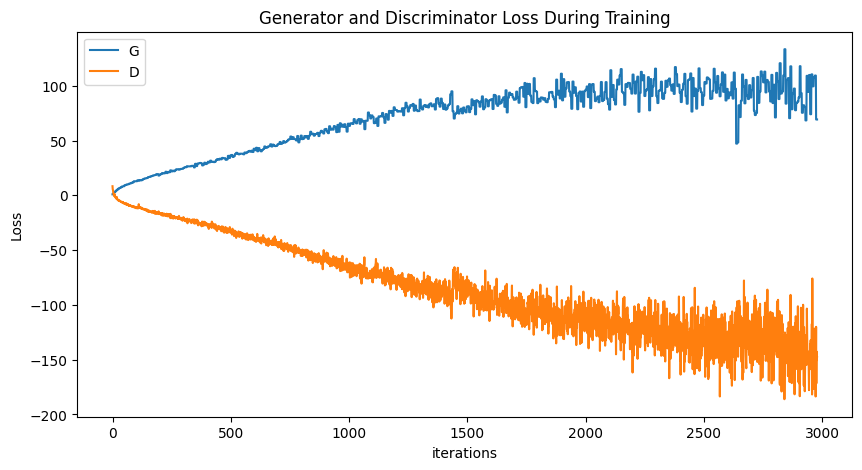

In [224]:
# Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Show animation of sig_list

# plt.suptitle("Generated Windows")
fig = plt.figure(figsize=(8,8))
ims = [plt.plot(i[0].T, animated=True) for i in sig_list[100:]]
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# ims = []
# for sig in sig_list:
#     fig, axes = plt.subplots(3, 3, figsize=(15, 5))
#     for i in range(3):
#         for j in range(3):
#             axes[i,j].plot(sig[-1][i,0].numpy())
#             axes[i,j].plot(sig[-1][i,1].numpy())
#             axes[i,j].plot(sig[-1][i,2].numpy())
#             axes[i,j].axis("off")
#     ims.append(axes[i,j].lines)

HTML(ani.to_jshtml())

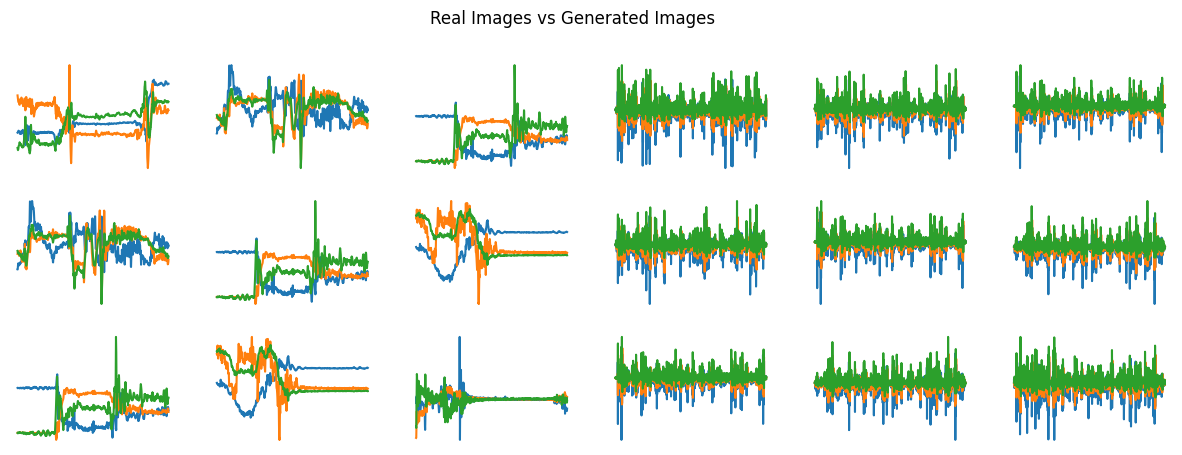

In [212]:
# Real Images vs. Fake Images
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
# standardize
real_batch[0] = (real_batch[0] - real_batch[0].mean(dim=2,keepdim=True)) / real_batch[0].std(dim=2,keepdim=True)
fig, axes = plt.subplots(3, 6, figsize=(15, 5))

plt.suptitle("Real Images vs Generated Images")
# Plot the real images
for i in range(3):
    for j in range(3):
        axes[i,j].plot(real_batch[0][i+j,0].numpy())
        axes[i,j].plot(real_batch[0][i+j,1].numpy())
        axes[i,j].plot(real_batch[0][i+j,2].numpy())
        axes[i,j].axis("off")

# Plot the fake images from the last epoch
for i in range(3):
    for j in range(3,6):
        axes[i,j].plot(sig_list[-1][i+j,0].numpy())
        axes[i,j].plot(sig_list[-1][i+j,1].numpy())
        axes[i,j].plot(sig_list[-1][i+j,2].numpy())
        axes[i,j].axis("off")